#8. GO/STOP! - Object Detection 시스템 만들기

## 8.0) 텐서플로 기초지식


###tf.reshape(원본 텐서, 변환 텐서 차원)
 원본 텐서가 (6,)의 차원을 가지는 [0, 1, 2, 3, 4, 5]라고 했을 때, 변환 텐서 차원이 [2, 3]이라고 하면

> [ [0,1,2]

> [3,4,5] ] 

의 형태로 변환해준다. 행렬과 마찬가지로 앞쪽이 행, 뒤쪽이 열임에 유의

*numpy의 경우 np.arrange(원본 텐서).reshape(변환 텐서 차원)*으로 사용

###tf.cast(텐서, 텐서의 dtype)

 텐서의 각 요소들의 dtype을 변경해준다. dtype=tf.int32 와 같이 비트수를 뒤에 붙여 표시해주어야함

###tf.concat([텐서1, 텐서2,....], axis=)

 같은 차원을 가지는 텐서끼리 연결해준다. 이 때 axis는 차원의 index처럼 작용한다.

 2차원인 경우 axis=0은 행 차원, axis=1은 열차원, 인덱스의 -1처럼 역순으로도 작용가능

 그냥 테트리스처럼 합쳐지는 형태라 합쳐진 결과 텐서의 차원은 변하지 않는다.

 > [[0,1]   <-텐서 1과   [[4, 5] <- 텐서 2를 axis=1(열기준)으로 합체 해주면
                       
 > [2,3]] ㅡㅡㅡㅡㅡ [6,7]]

 > [[0,1,4,5]

 > [2,3,6,7]]   

 이런 모양으로 합쳐져 차원(Rank)는 그대로 2이고 shape만 2 by 4로 변화한다.

###tf.stack([텐서1, 텐서2,....], axis=)

같은 차원을 가지는 텐서끼리 연결해주는 것은 같지만, axis를 축으로 해서
새로운 차원을 하나 정해서 그 방향으로 각 텐서들을 쌓는다.

 > [0,1] <- 텐서 1과 [2,3] <- 텐서 2를 axis=0(행기준)으로 쌓으면

 > [[0,1]

 > [2,3]]

 위와 같이 행방향으로 차원이 늘어나 2차원의 행렬로 변화한다.

마찬가지로 axis=1(열기준)으로 쌓으면

> [[0, 2]

> [1, 3]]  

열방향으로 차원이 늘어나 2차원의 행렬로 바꿀 수 있다.

### tf.expand_dims(원본 텐서, axis=)
원본 텐서의 차원에 axis에 해당하는 인덱스에 1차원을 끼워넣는다.

(2, 2)의 텐서에 axis=0에 넣는 경우 (1, 2, 2), axis=1에 넣는경우 (2, 1, 2)가 되는 방식이다.

### tf.meshgrid(텐서1, 텐서2)
(보통) 1차원을 가지는 두 텐서를 가로축(행 성분)은 텐서 1의 크기만큼

세로축은 텐서 2의 크기만큼 broadcasting해준다.

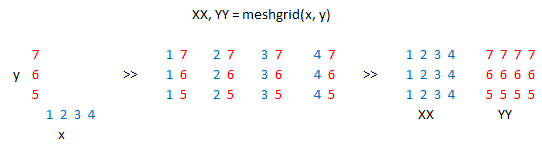

결과값은 2차원을 가지는 두 텐서(행렬벡터)로 출력된다.

### tf.tile(텐서1, 텐서2)
기본 요소인 텐서1을 기본 타일로 해서, 텐서2의 각 차원을 축으로 하여 성분만큼  붙여넣어 준다.

이 때 차원은 당연히 , 각각 차원에 붙여넣어지므로 repeat나 reshape의 효과를 줄 수 있다.

텐서 1이

>[[0,1],

> [2,3]]

형태의 (2,2) 텐서 일 때, 텐서 2가 (2,1)이라면, 첫번째 차원(행 차원)으로

두 번 타일 까는것처럼 붙여넣어주면 된다. 따라서

>[[0,1],

> [2,3],

>[0,1],

> [2,3]]

모양의 (4,2) 형태를 가지게 된다.

반대로 텐서 2가 (1,2)라면, 두번째 차원(열 차원)으로 두번 타일 깔듯이 붙여주면 되므로

>[[0,1,0,1],

> [2,3,2,3]]

이렇게 (2,4) 형태를 가진다.

## 8.1) KITTI 데이터셋 준비

In [77]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [78]:
#DATA_PATH = os.getenv('HOME') + '/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/object_detection/data'
#'HOME'을 상대위치로 지정하면 윈도우랑 다르게 코랩 내에 root폴더에 들어간다... 

In [79]:
DATA_PATH = os.getcwd()
#현재 파일위치 폴더를 지정하면 기본값인 /content 폴더로 이동하므로 여기에 +로 주소를 붙이면 정상적으로 현재 주소를 찾을 수 있다.
print(DATA_PATH)

/content/drive/My Drive/Colab Notebooks/아이펠/GoingDeeper/object_detection/data


In [80]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir='/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/object_detection/data',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

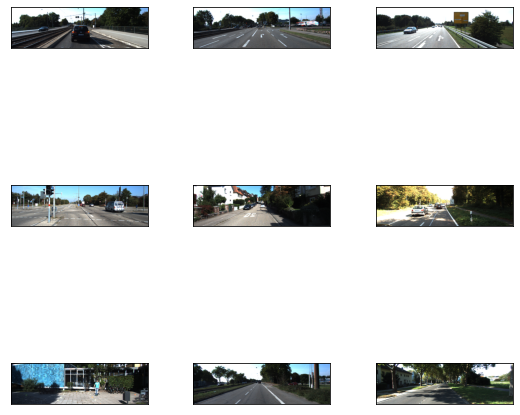

In [81]:
_ = tfds.show_examples(ds_train, ds_info)

In [82]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

##8.2) 데이터 직접 확인하기

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([ 1.8 , -2.46, -1.91, -1.79, -1.74,  1.75,  1.69,  1.69,  2.98],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[0.32216   , 0.280314  , 0.5558133 , 0.38116747],
       [0.00266667, 0.8240902 , 0.44618666, 0.99919486],
       [0.16693333, 0.6039855 , 0.5565867 , 0.78455716],
       [0.31898665, 0.5506441 , 0.5615467 , 0.6548551 ],
       [0.40882668, 0.5264573 , 0.56498665, 0.59694844],
       [0.39856   , 0.3368438 , 0.54826665, 0.40666667],
       [0.44093335, 0.36485508, 0.55744   , 0.4089855 ],
       [0.46477333, 0.38619968, 0.55896   , 0.42543477],
       [0.5038933 , 0.636715  , 0.61098665, 0.70308375]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(9, 3), dtype=float32, numpy=
array([[1.51, 1.55, 3.92],
       [1.5 , 1.53, 3.37],
       [1.47, 1.56, 3.16],
       [1.48, 1.56, 3.62],
       [1.39,

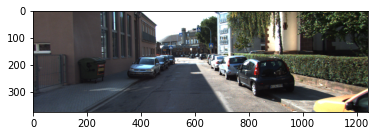

In [83]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

In [84]:
print(objects)

{'alpha': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([ 1.8 , -2.46, -1.91, -1.79, -1.74,  1.75,  1.69,  1.69,  2.98],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[0.32216   , 0.280314  , 0.5558133 , 0.38116747],
       [0.00266667, 0.8240902 , 0.44618666, 0.99919486],
       [0.16693333, 0.6039855 , 0.5565867 , 0.78455716],
       [0.31898665, 0.5506441 , 0.5615467 , 0.6548551 ],
       [0.40882668, 0.5264573 , 0.56498665, 0.59694844],
       [0.39856   , 0.3368438 , 0.54826665, 0.40666667],
       [0.44093335, 0.36485508, 0.55744   , 0.4089855 ],
       [0.46477333, 0.38619968, 0.55896   , 0.42543477],
       [0.5038933 , 0.636715  , 0.61098665, 0.70308375]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(9, 3), dtype=float32, numpy=
array([[1.51, 1.55, 3.92],
       [1.5 , 1.53, 3.37],
       [1.47, 1.56, 3.16],
       [1.48, 1.56, 3.62],
       [1.39, 1.54, 4.6 ],
       [1.4 , 1.62, 4.26],
       [1.46, 1.52, 3.48],
       [1.39

bbox가 데이터에서 찾고자하는 바운딩 박스의 label이며

KITTI의 경우 (좌상단x, 좌상단y, 우하단x, 우하단y)의 형식으로 정렬된다고 한다.

(정리 출처 https://velog.io/@jaeha0725/Object-Detection-Label-COCO-YOLO-KITTI)

numpy array shape는 (9, 4)이므로, 데이터에는 박스가 총 9개임을 알 수 있다.

> 이유는 잘 모르겠는데 여기 데이터는 위와 같은 bbox label을 사용하지 않은거 같다.



In [85]:
img.size

(1242, 375)

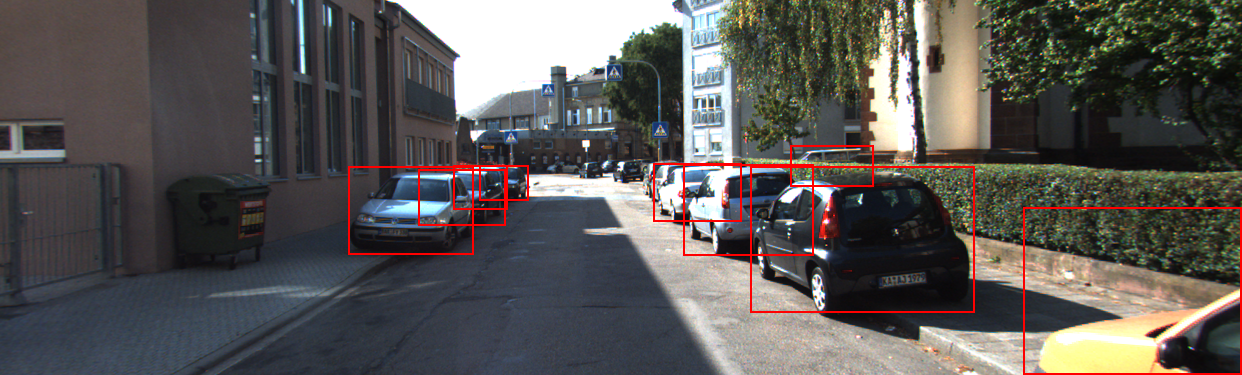

In [86]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    width, height = img.size

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    x_min=object_bbox[:,1]*width
    x_max=object_bbox[:,3]*width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 8.3) RetinaNet


### Focal Loss
 배경에 대한 과도한 학습을 방지하고자 교차엔트로피를 수정해서 사용

image.png

modulating terms은 0보다크고 1보다 작은 수이므로 γ가 커짐에따라 작은 값을 가진다.

때문에 타겟값(전경)이 아닌 배경에 대한 Loss함수값을 줄이는 역할을 해준다

### FPN(Feature Pyramid Network)

특성을 피라미드처럼 쌓음 -> upsampling(확대) 과정을 통해 피라미드형 층을 만들고

같은 receptive field 내에서 다양한 깊이로 예측이 가능하도록 한다.

## 8.4) 데이터 준비

### 데이터 파이프라인
1. x와 y좌표 위치 교체
2. 무작위로 수평 뒤집기(Flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

기본적으로 RetinaNet이 다루는 데이터타입이 여기서 사용한 KITTI 데이터와 달라서 수정해주는 듯하다.

In [87]:
#1. x와 y좌표 위치 교체
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

bbox에 나타난 타겟레이블을 변경해준다.

데이터셋 설명에서 bbox의 -1차원은 각각 left, top, right, bottom pixel coordinates 였는데, x,y를 변경해주게 된다면

top, left, bottom, right를 가지게 될 것이다.

tf.stack을 통해 (:, 4)차원을 가지는 bbox label이 만들어진다.

이유는 모르겠지만, 이러한 데이터셋이 표준인것 같다..

In [88]:
#2. 무작위로 수평 뒤집기(Flip)
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

랜덤한균등분포의 반만큼(=무작위로 반을) augmentation 해줄때처럼 좌우를 뒤집는다.

딱히 이유는 모르겠다. bbox label도 같은 방식으로 뒤집어준다.

(원점 위치가 바뀌므로 수식이 변환되어야 함에 유의)

In [89]:
#3. 이미지 크기변환 및 패딩
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

이미지의 크기를 일괄적으로 바꾸면 target들이 사라져버릴 위험이 있으므로,

최대 최소크기를 정해서 변환해 주되, 하나의 receptive field가 가지는 영역의 크기가 동일하도록

stride에 맞게 padding을 추가해준다.

변환할때 변환후의 이미지의 shape와 원본과의 ratio도 같이 리턴해주었다.

math.ceil(버림처리해주는 함수)

tf의 numpyarray형식 tensor도 나눗셈 연산후 알아서 float으로 변환되지만 알아서 버림처리 후 다시 int로 변환해준거 같다.


In [90]:
#4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

bbox의 좌상단, 우하단 점들을 나타내는 형식에서, 정중앙 점과 w, h를 나타내는 형식으로 변환해주었다.

신기하게 x축 y축 성분끼리 더해지고 알아서 unpacking되는거 같다.


In [91]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

### 인코딩

앵커박스 : 하나의 receptive field를 가지는 cell영역에 임의로 만든 박스

FPN은 각 pyramid마다 각각의 앵커박스를 만드므로 더 많이 필요하다.

대충 유추해보건대 피라미드는 32픽셀, 64픽셀, 128픽셀, 256픽셀, 512픽셀을 각각 범위로 가지는 5개의 층이 있으며,

각 셀은 기본적으로각각 가로세로(종횡)비가 1:1, 2:1, 1:2인 사각형으로 구성되어 있는데

각각 scaling factor인 2^0, 2^(1/3), 2^(2/3)비율을 곱해주어

하나의 cell에는 총 3 * 3 9개의 앵커박스를 만들어야함




In [92]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()
        """
        앵커박스는 1개 이상 오브젝트를 가지며, 사진 내에 따로 표현되므로,
        클래스를 선언해주고 __init__아래 각 매개변수들을 매서드로 지정해준다. (클래스안에서만 사용가능?)
        aspect_ratios : bbox의 가로축과 세로축의 비(1차원, 3개)
        scales : bbox의 크기 비율(1차원, 3개)
        num_anchors : 박스의 종횡비 x scales 두 차원의 곱 여기서는 총 9개
        여기 리스트를 증가시킴으로써 앵커박스의 개수를 늘릴 수 있을 것이다. 
        strides : 층에 따라 나뉜 cell들이 slide할때 겹치지 않게 이동하므로 같이 2의 배수로 증가해야 하는것 같다.
        areas : 가로 32픽셀이면, 우리가 확인하는 그림의 cell은 가로 32, 세로 32 즉 32^2이 된다.
        anchor_dims : 아래서 계산된 dimention을 가지는 것 같다. 아래서 확인해봄
        """


    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

        """
        dims는 리스트(처럼 보이지만 numpy array로 변환됨)
        1차원의 aspect_ratios의 요소와 anchor_height, anchor_width 2차원을 stack으로 결합했으니까 3차원
        acor_dims은 3차원인데 이를 또 stack해주었으므로 anchor_dims_all은 4차원이 된다.
        """

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )
        """
        _가 붙은 함수는 private함수로 다른 곳에서 import 할때 가져오지 않는 특성을 가진다고 한다.
        어째서 2개로 나누어 놓았는지는 이해 불가...
        rx, ry는 feature의 가로와 세로에 따라 가질 수 있는 값들의 리스트
        tf.meshgrid는 두 1차원 변수 rx, ry를 각각 (rx × ry)의 차원을 가지는 행렬로 broadcating 해준뒤
        2차원 행렬간 stack연산을 하므로 3차원의 결과를 가진다.
        strides는 1차원이지만 []인덱싱을 통해서 하나의 값만 뽑아내므로(스칼라값이 됨) 첫줄의 centers는 그대로 3차원이다
        두번째 줄에서는 (rx, ry, 1, 1)를 가진 4차원으로 expand
        세번째 줄에서 tile차원은 이어붙이기를 통해 기존 centers 차원의 axis를 맞춰서 [1, 1, self._num_anchors, 1]
        다시말해 num_anchors차원만 복사하는 방식으로 broadcasting된다.
        다시 이를 tile 연산을 통해 h, w 차원으로 복사해준다
        총 achors의 차원은 리턴값의 차원과 유사한 보양이 된다.
        """

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [93]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )
    # 레이블 boxs를 적절하게 변화

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)
    '''
    무작위로 만들어진 boxes와 레이블 boxes를 비교해서
    IoU를 구하는 과정인거 같다. 마찬가지로 두 박스의 교집합 / 합집합을 통해 구한다.
    '''

In [94]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )
        """
        같은 모형의 사각형만 있으면 안되니 앵커박스들의 분산을 지정해서 
        그 크기만큼 랜덤하게 변화시켜주는거 같아. 가로 0.1, 세로 0.2를 사용하는 것은 관례? 라고 한다.
        정확한 박스가 안찾아 지는 경우 변화시킬수 있는 파라미터라고 봐도 될꺼 같다.
        """

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )
        """
        match_iou, ignore_iou 두 인수를 통해서 여러개의 앵커박스 중 적절한거만 골라내는 작업
        """

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target


    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

## 8.5) 모델 작성

### Feature Pyramid

In [95]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [96]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [97]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [98]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

In [99]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

    ## 8.6) 모델 학습


In [100]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

In [101]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [102]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [103]:
"""
model_dir =  os.getcwd() + '/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/object_detection/data/checkpoints/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 1

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)
"""


'\nmodel_dir =  os.getcwd() + \'/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/object_detection/data/checkpoints/\'\ncallbacks_list = [\n    tf.keras.callbacks.ModelCheckpoint(\n        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),\n        monitor="loss",\n        save_best_only=False,\n        save_weights_only=True,\n        verbose=1,\n    )\n]\n\nepochs = 1\n\nmodel.fit(\n    train_dataset,\n    validation_data=val_dataset,\n    epochs=epochs,\n    callbacks=callbacks_list\n)\n'

## 8.7) 결과 확인하기


In [104]:
%cd /content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/object_detection/data
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/object_detection/data/data.zip'

/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/object_detection/data
replace stop_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [105]:
model_dir = os.getcwd() + '/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

In [106]:
print(model_dir)

/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/object_detection/data/checkpoints/


In [107]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [108]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [109]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [110]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

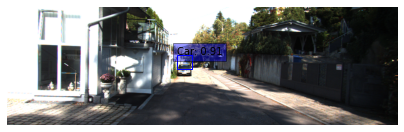

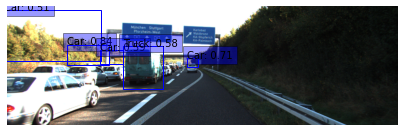

In [111]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

#여기서부터 실습



## 8.8) 프로젝트: 자율주행 보조 시스템 만들기

In [112]:
import tensorflow as tf

print(tf.__version__)

2.8.0


### 8.8.1) 자율주행 시스템 만들기

In [113]:
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/object_detection/data


In [127]:
import cv2
from google.colab.patches import cv2_imshow

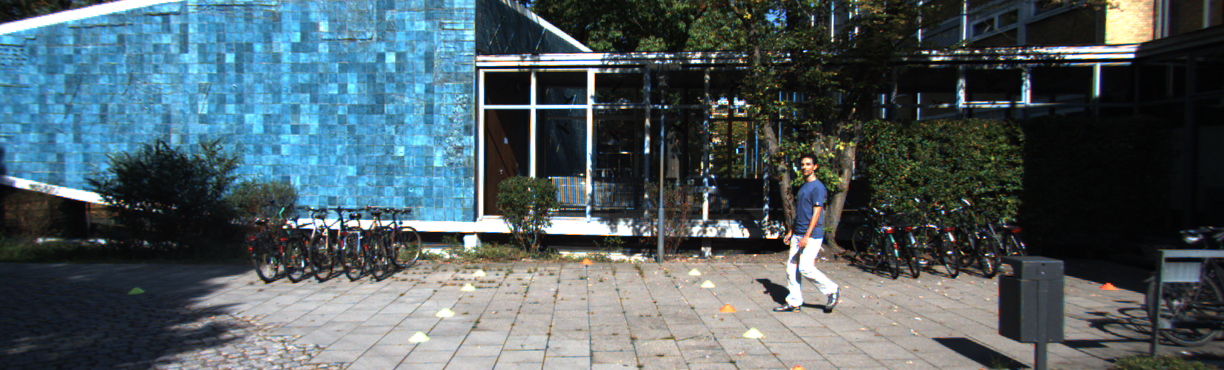

In [128]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
cv2_imshow(img)

In [223]:
def self_drive_assist(img_path, size_limit=300):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = tf.cast(img, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]]
    if 'Pedestrian' in class_names: #class_name에 보행자가 있다면
        print("Stop")
        return "Stop"
    elif 'Car' in class_names:      #class_name에 차가 있을때
        for idx, i in enumerate(class_names):   #class_name에서 인덱스랑 i를 순차적으로 꺼내서
            if (i == 'Car') and ((detections.nmsed_boxes[0][:num_detections][idx][2]-detections.nmsed_boxes[0][:num_detections][idx][0] >= size_limit) or (detections.nmsed_boxes[0][:num_detections][idx][3]-detections.nmsed_boxes[0][:num_detections][idx][1] >= size_limit)):
            # i가 Car이고 가로나 세로가 300보다 클 경우
                print('Stop')
                return "Stop"
                break #하나라도 있는 경우 Stop 리턴
        print("Go")
        return "Go"
        #for 루프 중에 하나도 안걸렸으면 Go 리턴
    else:
        print("Go")
        return "Go"

In [220]:
img_path = os.getcwd()+'/stop_4.png'

In [232]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
image = tf.cast(img, dtype=tf.float32)
input_image, ratio = prepare_image(image)
detections = inference_model.predict(input_image)
num_detections = detections.valid_detections[0]
class_names = [int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]]

In [227]:
print(class_names)

['Car']


In [228]:
detections.nmsed_boxes[0][:num_detections][0]

array([380.3016 , 163.3858 , 526.27673, 211.2526 ], dtype=float32)

In [222]:
detections.nmsed_boxes[0][:num_detections][0][2]-detections.nmsed_boxes[0][:num_detections][0][0] > 300

True

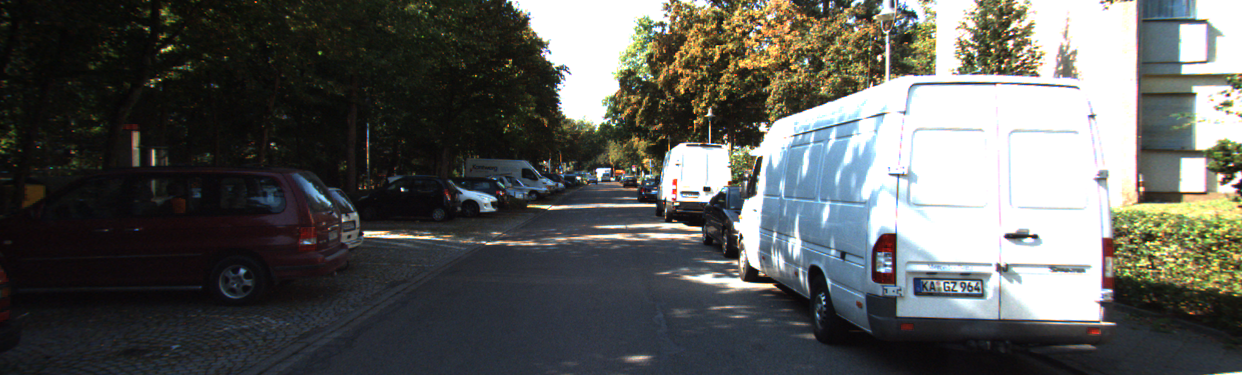

In [229]:
cv2_imshow(img)

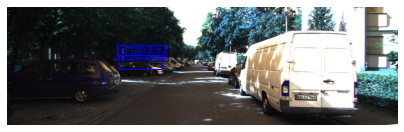

In [233]:
visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

디버깅 문제가 아니었다? (무리무리)

In [234]:
def self_drive_assist(img_path, size_limit=300):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = tf.cast(img, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]]
    if 'Pedestrian' in class_names: #class_name에 보행자가 있다면
        return "Stop"
    elif 'Car' in class_names:      #class_name에 차가 있을때
        for idx, i in enumerate(class_names):   #class_name에서 인덱스랑 i를 순차적으로 꺼내서
            if (i == 'Car') and ((detections.nmsed_boxes[0][:num_detections][idx][2]-detections.nmsed_boxes[0][:num_detections][idx][0] >= size_limit) or (detections.nmsed_boxes[0][:num_detections][idx][3]-detections.nmsed_boxes[0][:num_detections][idx][1] >= size_limit)):
            # i가 Car이고 가로나 세로가 300보다 클 경우
                return "Stop"
                break #하나라도 있는 경우 Stop 리턴
        return "Go"
        #for 루프 중에 하나도 안걸렸으면 Go 리턴
    else:
        return "Go"

### 8.8.2) 자율주행 시스템 평가하기

In [235]:
import os

def test_system(func):
    work_dir = os.getcwd()
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

In [236]:
test_system(self_drive_assist)

90점입니다.


## 8.9) 회고

난이도가 갈수록 상승하고 있다.

텐서플로뿐만 아니라 파이썬 Class, 선형대수 등등 다양한 베이스를 기본으로 하여 

이제 슬슬 적당히 이해하고 넘어가기에는 코드만 보고 이해하기 어려운 부분이 너무 많아지고 있다.

이후에 진행할 세그멘테이션이나 OCR의 기초가 되는 관계로 대충 넘어갈 수 없어서

상당히 많은 시간을 투자해서 얻어간 것도 많긴 하지만, 그래도 부족함이 많다.

여유가 된다면 파라미터를 바꿔보거나 학습도 직접시켜서 더 좋은 성능을 어떻게 하면 낼 수 있을까

백본이라던가... 들어도 이해 안되는 파트들 좀 체크하고 가고싶은데 갈길이 멀다.

이대로 제대로 된 해커톤을 할 수 있을까 고민이 깊어지고 있다.